# Step 1: Import Libraries
This cell imports necessary libraries such as pandas and numpy, which are essential for data analysis and numerical operations.

In [1]:
import pandas as pd
import numpy as np

# Step 2: Load and Inspect Data
This cell loads the dataset from a CSV file into a pandas DataFrame and prints the initial rows and basic information to understand the structure and contents of the data.

In [2]:
data = pd.read_csv("NQ_1_Min.csv")

df = data.copy()

print(df.head())
print(df.info())

              DateTime      Open      High       Low    Close  Volume
0  1/1/2020 6:01:00 PM  10874.25  10876.75  10867.50  10871.0     555
1  1/1/2020 6:02:00 PM  10870.75  10871.50  10868.00  10868.0     176
2  1/1/2020 6:03:00 PM  10867.75  10869.00  10867.00  10868.5     251
3  1/1/2020 6:04:00 PM  10869.00  10870.75  10869.00  10870.5     125
4  1/1/2020 6:05:00 PM  10870.50  10870.75  10868.75  10869.0      73
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861999 entries, 0 to 1861998
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   DateTime  object 
 1   Open      float64
 2   High      float64
 3   Low       float64
 4   Close     float64
 5   Volume    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 85.2+ MB
None


# Step 3: Convert DateTime Column
Converts the 'DateTime' column from a string format to a pandas datetime object for easier time-based operations.

In [3]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format="%m/%d/%Y %I:%M:%S %p")

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861999 entries, 0 to 1861998
Data columns (total 6 columns):
 #   Column    Dtype         
---  ------    -----         
 0   DateTime  datetime64[ns]
 1   Open      float64       
 2   High      float64       
 3   Low       float64       
 4   Close     float64       
 5   Volume    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 85.2 MB
None


# Step 4: Feature Engineering
Creates additional useful features:
- 'Color': Indicates if the candle is bullish or bearish.
- 'Candle_size': The total range of each candle.
- 'Body_size': The size of the candle body (difference between open and close prices).

In [4]:
df['Color'] = df['Close'] > df['Open']

df['Candle_size'] = df['High'] - df['Low']
df['Body_size'] = abs(df['Close'] - df['Open'])

print(df.head())

             DateTime      Open      High       Low    Close  Volume  Color  \
0 2020-01-01 18:01:00  10874.25  10876.75  10867.50  10871.0     555  False   
1 2020-01-01 18:02:00  10870.75  10871.50  10868.00  10868.0     176  False   
2 2020-01-01 18:03:00  10867.75  10869.00  10867.00  10868.5     251   True   
3 2020-01-01 18:04:00  10869.00  10870.75  10869.00  10870.5     125   True   
4 2020-01-01 18:05:00  10870.50  10870.75  10868.75  10869.0      73  False   

   Candle_size  Body_size  
0         9.25       3.25  
1         3.50       2.75  
2         2.00       0.75  
3         1.75       1.50  
4         2.00       1.50  


# Step 5: Session Classification
Classifies each data point into trading sessions based on the time of day:
- Asia (18:00–03:00)
- London (03:00–09:30)
- New York (09:30–17:00)

In [5]:
# Extract hours and minutes as floats (e.g., 18.5 = 6:30 PM)
times = df['DateTime'].dt.hour + df['DateTime'].dt.minute / 60

# Create empty session array
sessions = np.full(len(df), 'Other', dtype=object)

# Session rules
# Asia: 18:00 – 24:00 (6 PM – midnight) OR 0:00 – 3:00 AM
asia_mask = (times >= 18) | (times < 3)
# London: 3:00 – 9:30 AM
london_mask = (times >= 3) & (times < 9.5)
# NY: 9:30 AM – 5:00 PM
ny_mask = (times >= 9.5) & (times < 17)

# Apply session labels
sessions[asia_mask] = 'Asia'
sessions[london_mask] = 'London'
sessions[ny_mask] = 'New York'

# Assign to DataFrame
df['Session'] = sessions

print(df.head())
print(df.info())

             DateTime      Open      High       Low    Close  Volume  Color  \
0 2020-01-01 18:01:00  10874.25  10876.75  10867.50  10871.0     555  False   
1 2020-01-01 18:02:00  10870.75  10871.50  10868.00  10868.0     176  False   
2 2020-01-01 18:03:00  10867.75  10869.00  10867.00  10868.5     251   True   
3 2020-01-01 18:04:00  10869.00  10870.75  10869.00  10870.5     125   True   
4 2020-01-01 18:05:00  10870.50  10870.75  10868.75  10869.0      73  False   

   Candle_size  Body_size Session  
0         9.25       3.25    Asia  
1         3.50       2.75    Asia  
2         2.00       0.75    Asia  
3         1.75       1.50    Asia  
4         2.00       1.50    Asia  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861999 entries, 0 to 1861998
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   DateTime     datetime64[ns]
 1   Open         float64       
 2   High         float64       
 3   Low          float64      

# Step 6: Candlestick Pattern Recognition
Identifies bullish and bearish reversal patterns using candlestick analysis logic involving comparisons across consecutive bars.

In [6]:
# For easier reference
high = df['High'].values
low = df['Low'].values
close = df['Close'].values

# Shifted arrays
high1 = high[:-2]
low1 = low[:-2]
high2 = high[1:-1]
low2 = low[1:-1]
high3 = high[2:]
low3 = low[2:]
close3 = close[2:]

# Apply pattern logic
cond1 = high2 < high1           # Bar 2 high < Bar 1 high
cond2 = low2 < low1             # Bar 2 low < Bar 1 low
cond3 = low3 > low2             # Bar 3 low > Bar 2 low
cond4 = close3 > high2          # Bar 3 close > Bar 2 high

# Combine conditions
pattern_matches = cond1 & cond2 & cond3 & cond4

# Create full-size result array
pattern_flags = np.zeros(len(df), dtype=bool)
pattern_flags[2:] = pattern_matches

# Assign to DataFrame
df['bullish_reversal'] = pattern_flags

# Bearish pattern logic
cond1_bear = high2 > high1         # Bar 2 high > Bar 1 high
cond2_bear = low2 > low1           # Bar 2 low > Bar 1 low
cond3_bear = high3 < high2         # Bar 3 high < Bar 2 high
cond4_bear = close3 < low2         # Bar 3 close < Bar 2 low

pattern_matches_bear = cond1_bear & cond2_bear & cond3_bear & cond4_bear

# Full-size result array
bearish_flags = np.zeros(len(df), dtype=bool)
bearish_flags[2:] = pattern_matches_bear

# Assign to DataFrame
df['bearish_reversal'] = bearish_flags

print(df.head())

             DateTime      Open      High       Low    Close  Volume  Color  \
0 2020-01-01 18:01:00  10874.25  10876.75  10867.50  10871.0     555  False   
1 2020-01-01 18:02:00  10870.75  10871.50  10868.00  10868.0     176  False   
2 2020-01-01 18:03:00  10867.75  10869.00  10867.00  10868.5     251   True   
3 2020-01-01 18:04:00  10869.00  10870.75  10869.00  10870.5     125   True   
4 2020-01-01 18:05:00  10870.50  10870.75  10868.75  10869.0      73  False   

   Candle_size  Body_size Session  bullish_reversal  bearish_reversal  
0         9.25       3.25    Asia             False             False  
1         3.50       2.75    Asia             False             False  
2         2.00       0.75    Asia             False             False  
3         1.75       1.50    Asia              True             False  
4         2.00       1.50    Asia             False             False  


# Step 7: Trade Outcome Evaluation
Evaluates trade outcomes based on identified candlestick patterns, checking whether hypothetical trades would hit a target or a stop-loss within a specified number of bars ahead.

In [7]:
def evaluate_trade_numpy(df, pattern_col='bullish_reversal', bars_ahead=5):
    # Pre-extract arrays for fast access
    highs = df['High'].values
    lows = df['Low'].values
    opens = df['Open'].values

    outcomes = np.full(len(df), None, dtype=object)

    pattern_indices = np.where(df[pattern_col].values)[0]

    for i in pattern_indices:
        if i < 2 or i + bars_ahead >= len(df):
            continue

        entry_idx = i + 1
        stop = lows[i - 1]  # 2nd bar's low
        entry = opens[entry_idx]
        risk = entry - stop
        target = entry + risk

        if risk <= 0:
            continue

        future_highs = highs[entry_idx : entry_idx + bars_ahead]
        future_lows = lows[entry_idx : entry_idx + bars_ahead]

        # Check for stop/target conditions
        for high, low in zip(future_highs, future_lows):
            if low <= stop and high >= target:
                break  # Discard: both hit
            elif high >= target:
                outcomes[entry_idx] = True
                break
            elif low <= stop:
                outcomes[entry_idx] = False
                break

    return pd.Series(outcomes, index=df.index)

df['bullish_reversal_outcome'] = evaluate_trade_numpy(df, bars_ahead=5)

def evaluate_trade_numpy_bearish(df, pattern_col='bearish_reversal', bars_ahead=5):
    highs = df['High'].values
    lows = df['Low'].values
    opens = df['Open'].values

    outcomes = np.full(len(df), None, dtype=object)

    pattern_indices = np.where(df[pattern_col].values)[0]

    for i in pattern_indices:
        if i < 2 or i + bars_ahead >= len(df):
            continue

        entry_idx = i + 1
        stop = highs[i - 1]  # 2nd bar's high
        entry = opens[entry_idx]
        risk = stop - entry
        target = entry - risk

        if risk <= 0:
            continue

        future_highs = highs[entry_idx : entry_idx + bars_ahead]
        future_lows = lows[entry_idx : entry_idx + bars_ahead]

        for high, low in zip(future_highs, future_lows):
            if low <= target and high >= stop:
                break  # Discard: both hit
            elif low <= target:
                outcomes[entry_idx] = True
                break
            elif high >= stop:
                outcomes[entry_idx] = False
                break

    return pd.Series(outcomes, index=df.index)

df['bearish_reversal_outcome'] = evaluate_trade_numpy_bearish(df, bars_ahead=5)

print(df.head())

             DateTime      Open      High       Low    Close  Volume  Color  \
0 2020-01-01 18:01:00  10874.25  10876.75  10867.50  10871.0     555  False   
1 2020-01-01 18:02:00  10870.75  10871.50  10868.00  10868.0     176  False   
2 2020-01-01 18:03:00  10867.75  10869.00  10867.00  10868.5     251   True   
3 2020-01-01 18:04:00  10869.00  10870.75  10869.00  10870.5     125   True   
4 2020-01-01 18:05:00  10870.50  10870.75  10868.75  10869.0      73  False   

   Candle_size  Body_size Session  bullish_reversal  bearish_reversal  \
0         9.25       3.25    Asia             False             False   
1         3.50       2.75    Asia             False             False   
2         2.00       0.75    Asia             False             False   
3         1.75       1.50    Asia              True             False   
4         2.00       1.50    Asia             False             False   

  bullish_reversal_outcome bearish_reversal_outcome  
0                     None      

# Step 8: Pattern Performance Analysis
Summarizes the trading performance, showing the number of wins, losses, and skipped or invalid trades for both bullish and bearish setups.

In [8]:
outcomes = df['bullish_reversal_outcome']

num_wins = outcomes.sum()                     # True == 1
num_skipped = outcomes.isna().sum()
num_losses = (outcomes == False).sum()

print(f"Wins:   {num_wins}")
print(f"Losses: {num_losses}")
print(f"Skipped/Invalid: {num_skipped}")

Wins:   35010
Losses: 34466
Skipped/Invalid: 1792523


In [9]:
outcomes = df['bearish_reversal_outcome']

num_wins = outcomes.sum()                     # True == 1
num_skipped = outcomes.isna().sum()
num_losses = (outcomes == False).sum()

print(f"Wins:   {num_wins}")
print(f"Losses: {num_losses}")
print(f"Skipped/Invalid: {num_skipped}")

Wins:   36370
Losses: 34961
Skipped/Invalid: 1790668


# Step 9: Profit and Loss Calculation
Calculates cumulative profit and loss (PnL) for each trade signal (bullish and bearish), generating equity curves to visualize the strategy's performance over time.

In [10]:
df['pnl_bullish'] = df['bullish_reversal_outcome'].map({True: 1, False: -1}).fillna(0)
df['pnl_bearish'] = df['bearish_reversal_outcome'].map({True: 1, False: -1}).fillna(0)

df['equity_bullish'] = df['pnl_bullish'].cumsum()
df['equity_bearish'] = df['pnl_bearish'].cumsum()

df['equity_total'] = df['pnl_bullish'] + df['pnl_bearish']
df['equity_total'] = df['equity_total'].cumsum()

In [11]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df['DateTime'], df['equity_bullish'], label='Bullish Reversal Equity')
plt.plot(df['DateTime'], df['equity_bearish'], label='Bearish Reversal Equity')
plt.plot(df['DateTime'], df['equity_total'], label='Total Equity')
plt.title('Equity Curve by Trade Type')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL (R)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [14]:
def evaluate_reversal_classifier(df, outcome_col, feature_cols=None, test_size=0.2, random_state=42):
    """
    Train and evaluate a RandomForestClassifier on a reversal outcome column.

    Parameters:
    - df: Pandas DataFrame containing features and outcome
    - outcome_col: Name of the column with trade outcome (e.g., 'bullish_reversal_outcome')
    - feature_cols: List of features to use (default uses ['Color', 'Candle_size', 'Body_size', 'Session'])
    - test_size: Proportion of test set (default 0.2)
    - random_state: Seed for reproducibility

    Returns:
    - trained classifier
    - classification report
    - feature importances
    """

    # Default features
    if feature_cols is None:
        feature_cols = ['Color', 'Candle_size', 'Body_size', 'Session']

    # Filter rows with valid outcome
    valid_rows = df[df[outcome_col].isin([True, False])].copy()

    # One-hot encode categorical features
    X = pd.get_dummies(valid_rows[feature_cols])
    y = valid_rows[outcome_col].astype(int)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=True
    )

    # Train classifier
    clf = RandomForestClassifier(class_weight='balanced', random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Output metrics
    report = classification_report(y_test, y_pred, output_dict=False)
    feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

    print(f"\n--- Results for {outcome_col} ---")
    print(report)
    print("\nTop Feature Importances:")
    print(feature_importances.head(10))

    return clf, report, feature_importances

clf_bull, report_bull, importance_bull = evaluate_reversal_classifier(df = df, outcome_col = 'bullish_reversal_outcome')
clf_bear, report_bear, importance_bear = evaluate_reversal_classifier(df = df, outcome_col = 'bearish_reversal_outcome')


--- Results for bullish_reversal_outcome ---
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      6961
           1       0.76      0.76      0.76      6935

    accuracy                           0.76     13896
   macro avg       0.76      0.76      0.76     13896
weighted avg       0.76      0.76      0.76     13896


Top Feature Importances:
Color               0.611585
Candle_size         0.195568
Body_size           0.187867
Session_New York    0.001910
Session_Asia        0.001610
Session_London      0.001133
Session_Other       0.000327
dtype: float64

--- Results for bearish_reversal_outcome ---
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      7058
           1       0.76      0.75      0.76      7209

    accuracy                           0.76     14267
   macro avg       0.76      0.76      0.76     14267
weighted avg       0.76      0.76      0.76     14267


Top Featu

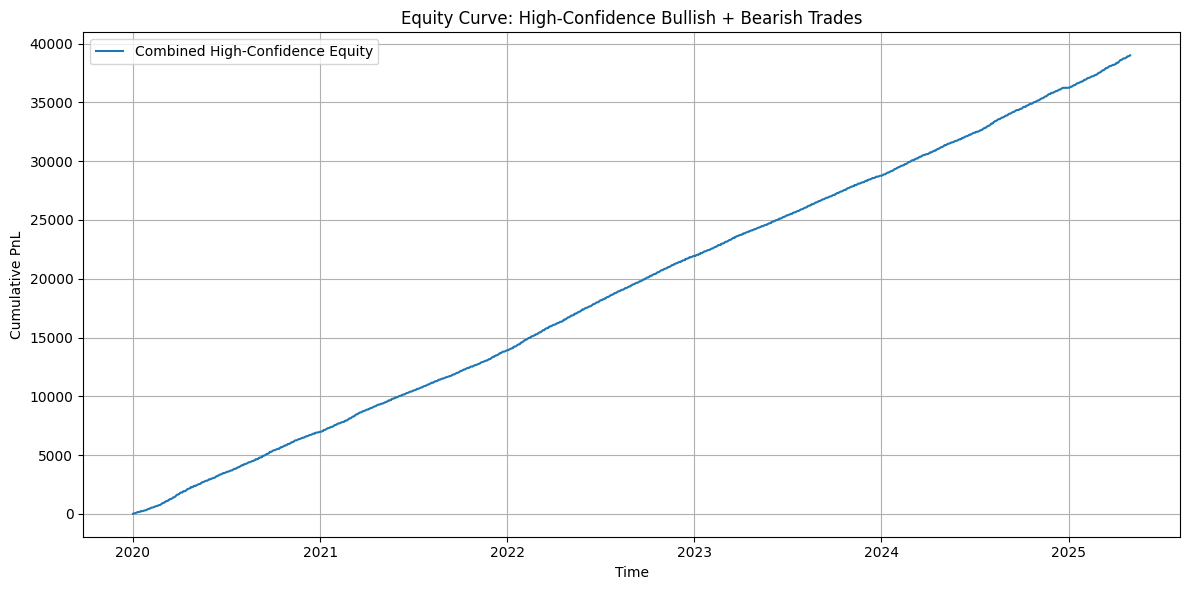

In [15]:
def unified_high_confidence_strategy(df, clf_bull, clf_bear, prob_threshold=0.7, feature_cols=None):
    if feature_cols is None:
        feature_cols = ['Color', 'Candle_size', 'Body_size', 'Session']

    def prepare_data(outcome_col):
        valid = df[df[outcome_col].isin([True, False])].copy()
        X = pd.get_dummies(valid[feature_cols])
        y = valid[outcome_col].astype(int)

        # Ensure same columns
        model = clf_bull if outcome_col == 'bullish_reversal_outcome' else clf_bear
        for col in model.feature_names_in_:
            if col not in X:
                X[col] = 0
        X = X[model.feature_names_in_]

        # Predict probability
        proba = model.predict_proba(X)[:, 1]
        valid['model_confidence'] = proba
        valid['pnl'] = valid[outcome_col].map({True: 1, False: -1})
        return valid[valid['model_confidence'] >= prob_threshold].copy()

    # Process both directions
    bullish_trades = prepare_data('bullish_reversal_outcome')
    bearish_trades = prepare_data('bearish_reversal_outcome')

    # Combine & sort chronologically
    all_trades = pd.concat([bullish_trades, bearish_trades])
    all_trades = all_trades.sort_values('DateTime')
    all_trades['equity'] = all_trades['pnl'].cumsum()

    return all_trades[['DateTime', 'pnl', 'equity', 'model_confidence']]

# Run strategy
combined_trades = unified_high_confidence_strategy(df, clf_bull, clf_bear, prob_threshold=0.7)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(combined_trades['DateTime'], combined_trades['equity'], label='Combined High-Confidence Equity')
plt.title('Equity Curve: High-Confidence Bullish + Bearish Trades')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
def evaluate_performance(trades_df):
    """
    Print performance statistics for filtered trades.
    
    Parameters:
    - trades_df: DataFrame with 'pnl' and optionally 'model_confidence' and 'DateTime'
    """
    num_trades = len(trades_df)
    num_wins = (trades_df['pnl'] == 1).sum()
    num_losses = (trades_df['pnl'] == -1).sum()
    win_rate = num_wins / num_trades if num_trades else 0

    avg_pnl = trades_df['pnl'].mean()
    std_pnl = trades_df['pnl'].std()
    sharpe = (avg_pnl / std_pnl) * np.sqrt(252) if std_pnl != 0 else np.nan  # annualized Sharpe

    print(f"Strategy Performance")
    print(f"----------------------------------------")
    print(f"Total Trades:     {num_trades}")
    print(f"Wins:             {num_wins}")
    print(f"Losses:           {num_losses}")
    print(f"Win Rate:         {win_rate:.2%}")
    print(f"Average PnL:      {avg_pnl:.2f}")
    print(f"Sharpe Ratio:     {sharpe:.2f}")
    print(f"Max Equity:       {trades_df['equity'].max():.2f}")
    print(f"Min Equity:       {trades_df['equity'].min():.2f}")

evaluate_performance(combined_trades)

Strategy Performance
----------------------------------------
Total Trades:     50211
Wins:             44613
Losses:           5598
Win Rate:         88.85%
Average PnL:      0.78
Sharpe Ratio:     19.60
Max Equity:       39015.00
Min Equity:       1.00


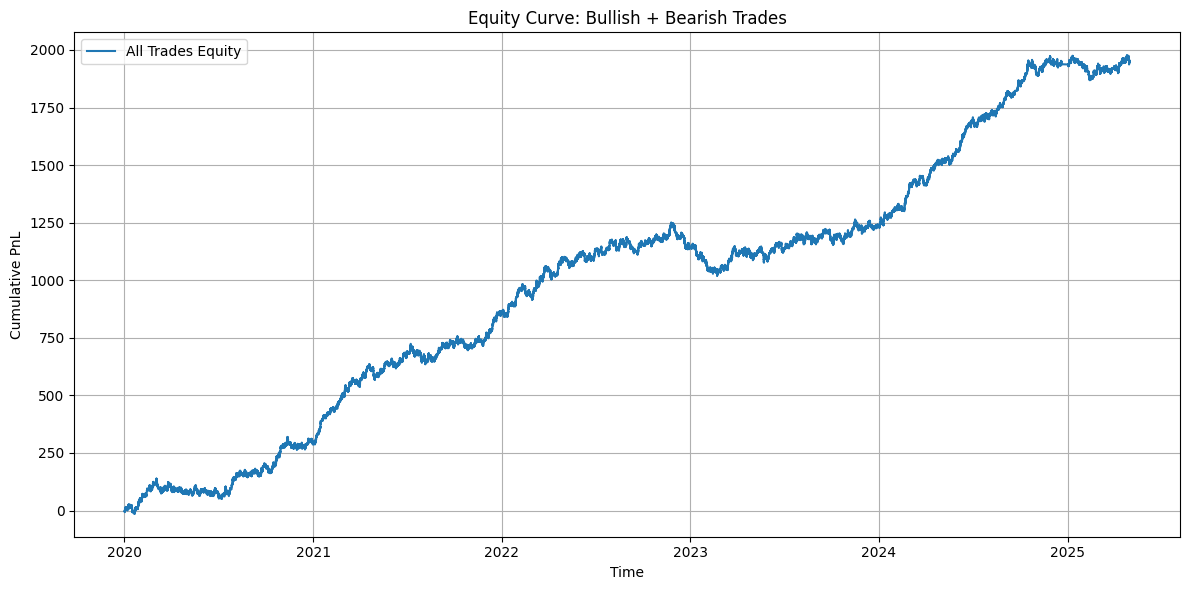

In [18]:
def unfiltered_strategy(df):
    """
    Returns all valid bullish + bearish trades with raw PnL and equity.
    """
    bullish = df[df['bullish_reversal_outcome'].isin([True, False])].copy()
    bearish = df[df['bearish_reversal_outcome'].isin([True, False])].copy()

    bullish['pnl'] = bullish['bullish_reversal_outcome'].map({True: 1, False: -1})
    bearish['pnl'] = bearish['bearish_reversal_outcome'].map({True: 1, False: -1})

    all_trades = pd.concat([bullish, bearish])
    all_trades = all_trades.sort_values('DateTime')
    all_trades['equity'] = all_trades['pnl'].cumsum()
    return all_trades[['DateTime', 'pnl', 'equity']]

all_trades = unfiltered_strategy(df)

plt.figure(figsize=(12, 6))
plt.plot(all_trades['DateTime'], all_trades['equity'], label='All Trades Equity')
plt.title('Equity Curve: Bullish + Bearish Trades')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
evaluate_performance(all_trades)

Strategy Performance
----------------------------------------
Total Trades:     140807
Wins:             71380
Losses:           69427
Win Rate:         50.69%
Average PnL:      0.01
Sharpe Ratio:     0.22
Max Equity:       1977.00
Min Equity:       -14.00
